## Narrative Embeddings for clinical report classification

Ok, so we have a database of clinical incident report, in the form of chronologic stories narrated by one of the healthcare professionnal concerned.

There's a lot of research papers trying to analyze narratives as chronological orderered series of events, with various actors. Using those tools might help greatly to classify our clinical report, every available words or documents vector embeddings are indeed lacking of any narrative representation. I am trying to create a 'narrative embedding' for my reports, that i will use to train and test multi-label classification model. 

This is a three steps project : 

1) Extracting event chains from my dataset according to the 2009 paper of Chambers https://www.usna.edu/Users/cs/nchamber/pubs/acl09-narrative-schema.pdf

2) Create Narrative Event Evolutionnary Graph (NEEG) according to the paper arXiv:1805.05081v2 

3) Implement a Scaled Graph neural network, i.e neural network that will take NEEG in input.

I use Spacy and the HuggingFace coreference parser to extract event chains from the database : https://github.com/huggingface/neuralcoref

In [1]:
# we load important packages and create our coreference parser

import pandas as pd
import numpy as np
import spacy
import neuralcoref

from tqdm import tqdm_notebook

from scipy.sparse import dok_matrix

import matplotlib.pyplot as plt
import networkx as nx

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

nlp = spacy.load('en')
neuralcoref.add_to_pipe(nlp,blacklist=False)

In [3]:
# we will use ASRS Human Factors related incidents database, containing 42005 narratives

df = pd.read_excel('datasets/ASRStotal.xlsx')
df.dropna(how='all', axis=1)


pd.set_option('mode.chained_assignment', None)

df_labelled = df[~ df['Human Factors'].isnull()]
df_labelled['Human Factors'] = df_labelled['Human Factors'].str.replace(' ','')
df_labelled['Human Factors'] = df_labelled['Human Factors'].str.split(';')
data = df_labelled.join(pd.DataFrame(mlb.fit_transform(df_labelled.pop('Human Factors')),
                        columns=mlb.classes_,
                        index=df_labelled.index))

narratives = np.array(data["Narrative"].map(lambda x: str(x).lower()))

print("the number of narratives is ", len(narratives))


the number of narratives is  20124


In [9]:
# we parse narratives to get events chains. We go into each coreference cluster to get references ancestor verb
# and create the chronological event chain (as we assume narratives to be strictly chronological).

stopVerbs = ["be","have"] 
countt = {'subj':0,'obj':0,'iobj':0}

def protagonists_parser(narrative) :
    doc2 = nlp(narrative)
    events_chains = []
    for cluster in doc2._.coref_clusters :
        events_chain = {'protagonist': cluster.main, 'events' : None }
        events = []
        for span in cluster.mentions :
            
            for token in span.root.ancestors :
                if token.pos_ == "VERB" and token.lemma_ not in stopVerbs : #and token.i > span.root.i :
                    negation = False
                    event = { 'id' : 0, 'subj': None ,'predicat': ["bad","bad"] ,'obj':None ,'iobj':None }
                    if span.root in token.children :
                        for t in token.children :
                            l = []
                            for t1 in t.subtree :
                                l.append(t1)
                            key = ""
                            if t.dep_ == "nsubj" or t.dep_ == "nsubjpass" :
                                key = 'subj'
                            if t.dep_ in ["dobj","obj","pobj","attr","acomp","agent","ccomp"]:
                                key = 'obj'
                            if t.dep_ in ["prep","advcl","advmod"] :
                                key="iobj"  
                            if t.dep_ == "neg":
                                negation = True
                            if key != "" :
                                event[key] = doc2[l[0].i:l[-1].i+1]
                                if t == span.root :
                                    if negation :
                                        event['predicat'] = ["not "+token.lemma_,key]
                                    else :
                                        event['predicat'] = [token.lemma_,key]
                                    countt[key] += 1
                        events.append(event)
        if len(events) > 0 :
            events_chain["events"] = events
            events_chains.append(events_chain)
    return(events_chains)
                    

# condensed view of a list of events chains
def display_chains(events_chains):
    for narrative_chains in events_chains :
        print(" ")
        for events_chain in narrative_chains :
            print(" ")
            print("the protagonist is : "+ str(events_chain["protagonist"]))
            s = ""
            for event in events_chain["events"] :
                s += str(event['predicat'][0]+"-"+event['predicat'][1])+" > "
                print(str(event['subj'])+" - "+str(event['predicat'][0]+"-"+event['predicat'][1])+" - "+str(event['obj'])+" - "+str(event['iobj']))
            print(s)    


In [10]:

E = []

for i in tqdm_notebook(range(20000,20100)):
    E.append(protagonists_parser(narratives[i]))
print("counttt", countt)
display_chains(E)
index = 0
for i in range(len(E)):
    for j in range(len(E[i])):
        for k in range(len(E[i][j]["events"])) :
            E[i][j]["events"][k]['id'] = index
            index += 1    
print("we have "+ str(len(E)) + " narratives, which amount to a total of "+  str(sum([len(l) for l in E])) +" events chains, for "+ str(index) +" events.")




counttt {'subj': 1573, 'obj': 423, 'iobj': 5}
 
 
the protagonist is : we
us - hold-subj - None - to avoid the rest of the arrival and shortcut to base leg runway
we - do-subj - the full arrival - None
we - use-subj - spoilers, flaps, and gear - None
atc - clear-obj - us - to 2,000 feet
None - clear-obj - us - for visual approach
we - notice-subj - glideslope - None
we - continue-subj - None - None
we - cross-subj - the faf - yet
atc - bad-bad - a low altitude alert and - as i noticed we were low
we - catch-subj - it - immediately
hold-subj > do-subj > use-subj > clear-obj > clear-obj > notice-subj > continue-subj > cross-subj > bad-bad > catch-subj > 
 
the protagonist is : visual approach
the first officer - arm-obj - the approach - None
arm-obj > 
 
the protagonist is : the first officer
the first officer - arm-subj - the approach - None
i - fail-subj - None - None
i - notice-subj - we were low - None
the first officer - climb-subj - None - back to faf altitude (1,800 feet)
arm-sub

we - experience-obj - an ra - commanding a climb
experience-obj > 
 
the protagonist is : a shallow descent
we - enter-obj - a shallow descent - at one point in the sequence
None - regard-obj - the descent - None
enter-obj > regard-obj > 
 
 
the protagonist is : i
i - remember-subj - the exact wording - None
i - assume-subj - that the right tank indication was related to the previous write-ups - None
i - allow-subj - None - thinking that the mel (minimum equipment list) was simple and would not preclude flight
i - find-subj - almost no communication with operations was possible so i repeatedly got off the aircraft to get agents to bring out food as we were not catered, delay kits and to get aircraft water service as we had not been not overnight - during the delay
i - get-subj - None - to get agents to bring out food as we were not catered, delay kits and to get aircraft water service as we had not been not overnight
i - need-subj - None - as i was getting no updates
i - get-subj - no

the protagonist is : a kit is used that is stored in the hangar bubble
paperwork - follow-iobj - None - however routinely a kit is used
follow-iobj > 
 
the protagonist is : so alternately plastic bags
so alternately plastic bags - use-subj - None - None
the plastic - melt-subj - None - to the pitot tubes
use-subj > melt-subj > 
 
the protagonist is : entire pitot tubes
None - cover-obj - entire pitot tubes - in 4 locations
all 4 pitot tubes - document-subj - None - as contaminated and later replaced
cover-obj > document-subj > 
 
the protagonist is : engines for oil service
None - run-obj - engines for oil service - None
the engines - run-subj - None - None
it - discover-subj - the plastic had melted to the pitot tubes - later
run-obj > run-subj > discover-subj > 
 
the protagonist is : all tasks
they - seem-subj - how trivial - None
seem-subj > 
 
 
the protagonist is : i
i - sit-subj - None - while he sat in the front seat
which - distract-obj - me - from providing enough of a brief

the protagonist is : my entire concern
None - prove-obj - my entire concern - None
None - put-obj - it - back in
prove-obj > put-obj > 
 
the protagonist is : it
it - need-subj - it's fine - None
need-subj > 
 
the protagonist is : it
it - get-subj - fixed.as an inflight instructor - None
get-subj > 
 
the protagonist is : this incident with [maintenance]
this incident with [maintenance] - isolate-subj - None - None
it - concern-subj - None - due to the dismissive and argumentative nature of the mechanic in question
it - create-subj - a culture whereby we do not want to report anything as broken - by being disrespectful to and dismissive of any employee with a safety concern
isolate-subj > concern-subj > create-subj > 
 
the protagonist is : we
we - want-subj - None - whereby
we - question-subj - ourselves - None
we - question-obj - ourselves - None
we - take-subj - None - None
we - stay-subj - quiet - simply
want-subj > question-subj > question-obj > take-subj > stay-subj > 
 
 
the p

i - clear-subj - None - on runway xx
i - continue-subj - None - on my base leg
i - fly-subj - None - None
i - proceed-subj - None - to land
i - apply-subj - brakes - None
atc - ask-obj - me - if i could get back onto a taxiway and proceed to the wash ramp
i - get-subj - None - back onto a taxiway
i - confirm-subj - i was able to do so and made my way back toward the [fbo] ramp - None
advise-subj > notify-subj > advise-subj > midfield-subj > fly-subj > continue-subj > inform-subj > tell-obj > clear-subj > continue-subj > fly-subj > proceed-subj > apply-subj > ask-obj > get-subj > confirm-subj > 
 
the protagonist is : the aircraft y
i - inform-obj - i was beyond my abeam point on my downwind leg - atc finished communicating with the aircraft y
inform-obj > 
 
the protagonist is : runway xx
None - roll-obj - the runway - None
roll-obj > 
 
the protagonist is : my aircraft
my aircraft - bounce-subj - None - into the air
the aircraft - begin-subj - None - None
the aircraft - turn-subj - ri

i - hold-subj - the completion of the checklist - pending the setting of the parking brake
shut-subj > realize-subj > apply-subj > notice-subj > understand-subj > put-obj > hold-subj > 
 
the protagonist is : we
we - touch-subj - None - in zzz
we - arrive-subj - None - when
we - instruct-subj - None - None
we - hold-subj - None - for about 25 minutes
we - give-subj - a new gate - from operations
we - taxi-subj - None - to [new gate]
we - park-subj - None - None
we - hold-subj - the shutdown checklist - pending the setting of the parking brake
touch-subj > arrive-subj > instruct-subj > hold-subj > give-subj > taxi-subj > park-subj > hold-subj > 
 
the protagonist is : our assigned gate
the gate - occupy-subj - None - when we arrived
our gate - become-subj - available - None
occupy-subj > become-subj > 
 
the protagonist is : the shutdown checklist
we - hold-obj - the shutdown checklist - pending the setting of the parking brake
hold-obj > 
 
the protagonist is : the parking brake
None -

None - fly-obj - the plane - first
None - fly-obj - the plane - None
fly-obj > fly-obj > 
 
the protagonist is : it
it - start-subj - None - None
start-subj > 
 
the protagonist is : the alerts
i - ignore-obj - the alerts - None
that - give-obj - the alerts - None
ignore-obj > give-obj > 
 
the protagonist is : my portable efb
i - check-obj - my portable efb - always
None - turn-obj - it - when not using it
None - not use-obj - it - when
check-obj > turn-obj > not use-obj > 
 
 
the protagonist is : i
i - conduct-subj - a cfi single engine - None
he - direct-obj - me - what airspeed to hold, how much bank to use, when to deploy flaps, etc
his instruction - lead-obj - me - to a very high final approach altitude
i - state-subj - , we are too high - None
i - continue-subj - None - trusting in his judgement as a dpe and giving in to the politics of student pilot vs dpe
i - think-subj - None - None
they - bad-bad - a phone number for a possible pilot deviation - once in contact with ground


the protagonist is : the first officer's fmc (flight management computer)
None - load-obj - the fmc - with the new route
load-obj > 
 
the protagonist is : we
we - receive-subj - a selcal (selective calling) - from gander radio asking if we had received our oceanic clearance
we - receive-subj - our oceanic clearance - None
receive-subj > receive-subj > 
 
the protagonist is : the flying first officer
the flying first officer - return-subj - None - from his rest break
i - debrief-obj - him - on the mistake
he - make-subj - None - None
None - bad-bad - the procedure as outlined in the manual - None
the first officer - acknowledge-subj - his mistake - None
return-subj > debrief-obj > make-subj > bad-bad > acknowledge-subj > 
 
the protagonist is : the mistake
the first officer - acknowledge-obj - his mistake - None
acknowledge-obj > 
 
 
the protagonist is : radios
they - change-subj - our arrival on the previous approach control frequency - due to landing on 24r versus 6l
change-subj > 


i - believe-subj - that the crew may have violated subpart (d) of far 117.17 flight duty period: augmented flight crew.(a) for flight operations conducted with an acclimated augmented flight crew, no certificate holder may assign and no flight crew member may accept an assignment if the scheduled flight duty period will exceed the limits specified in table c of this part.(b) if the flight crew member is not acclimated:(1) the maximum flight duty period in table c of this part is reduced by 30 minutes - None
call-subj > ask-subj > express-subj > emphasize-subj > believe-subj > 
 
the protagonist is : the pairing
the pairing - build-subj - None - legally
build-subj > 
 
the protagonist is : crew scheduler
crew scheduler - say-subj - that there were some odd codes popping up in his diagnostics but that he would consult with the manager when he arrived in a few minutes and get back to me if there were any problems - None
he - consult-subj - None - when he arrived in a few minutes and get b

i - distract-subj - by a discussion with my supervisor about whether we would retain our health care coverage while not being paid - additionally
i - realize-subj - aircraft - None
intend-subj > distract-subj > realize-subj > 
 
the protagonist is : we
we - retain-subj - our health care coverage - while not being paid
retain-subj > 
 
the protagonist is : they
they - answer-subj - None - None
they - answer-subj - None - None
answer-subj > answer-subj > 
 
 
the protagonist is : i
he - cross-subj - 4 departure streams - None
i - put-subj - a 5 mile j-ring - to keep track of his position
i - level-subj - 3 aircraft - and then handing them off to me
i - take-subj - a handoff - on an unknown
my d-side - ask-obj - me - about how i was holding up with the lack of pay
i - hold-subj - None - with the lack of pay
i - climb-subj - him - to 31,000 ft
i - get-subj - a response - None
i - get-subj - a response from the [b737] pilot - None
i - radio-subj - him - again
i - respond-subj - center, ther

None - switch-obj - them - to us
switch-obj > 
 
 
the protagonist is : i
i - start-subj - None - None
None - relieve-obj - me - None
None - relieve-obj - me - None
i - issue-subj - an amended alt clearance to aircraft - to stop at fl220
i - put-subj - a local int alt of fl220 - on aircraft
i - put-subj - int of fl240 - on the db (data block)
i - proceed-subj - None - with the briefing
i - walk-subj - None - None
i - go-subj - None - to see what was going on
i - listen-subj - i am unaware if there was an ra or not - to the frequency
i - climb-subj - aircraft y - to fl220
i - distract-subj - None - with all of the distractions with the government shutdown, not getting paid yet again, and the horrible morale throughout this building
i - sleep-subj - None - if at all some nights, to the distractions of this shutdown
i - add-subj - stress - so to deal with our financial situations caused by missing multiple paychecks
i - climb-subj - the ac - to fl220
start-subj > relieve-obj > relieve-obj

we - get-subj - a clearance to return to [our departure airport] and - ahead
None - bad-bad - more divert options - None
we - continue-subj - None - to [the departure airport]
we - land-subj - None - None
we - land-subj - None - sooner
we - get-subj - an amended clearance - None
we - coordinate-subj - a fuel dump to arrive at landing weight as to not have to generate an overweight landing inspection at zzzz - None
we - begin-subj - None - None
we - load-subj - the acars - manually
we - go-subj - None - back
we - inform-subj - not deferrable - stating there is a mechanic on field
we - need-subj - everyone to make this work - None
get-subj > bad-bad > continue-subj > land-subj > land-subj > get-subj > coordinate-subj > begin-subj > load-subj > go-subj > inform-subj > need-subj > 
 
the protagonist is : medlink
medlink - request-subj - the patient be put on the floor and turned on his side - None
him - lean-subj - None - in the seat
i - go-subj - None - to talk to the responders
i - ask-s

the protagonist is : the pic
the pic - agree-subj - None - immediately
agree-subj > 
 
 
the protagonist is : i
i - hold-subj - the ils approach system was being used for approaches to the runway 10l at fll - at the ils hold line
ground - ask-obj - me - to contact tower
i - call-subj - None - None
i - move-subj - he did not say taxi up [to] the hold short line - past the hold short line
hold-subj > ask-obj > call-subj > move-subj > 
 
the protagonist is : he
he - say-subj - taxi up - [to] the hold short line
he - say-subj - taxi - clearly
say-subj > say-subj > 
 
 
the protagonist is : i
i - experience-subj - a near midair collision - in the vicinity of byron airport (c83) in byron, california
i - operate-subj - a c172 - in the right closed traffic pattern for runway 30 at byron
i - initiate-subj - my descent for the approach to landing, where i discovered that another aircraft was actually directly underneath my aircraft - while in the right downwind abeam the 30 numbers
i - discover-

schedule-subj > not use-obj > 
 
the protagonist is : our
None - notify-obj - that the sensor was scheduled to go out at [this time] and that this was a prior coordinated event - None
notify-obj > 
 
 
the protagonist is : i
i - work-subj - aircraft x - at sector 92 enroute to pne
i - descend-subj - the aircraft - to hand off to allentown approach
i - switch-subj - communications - None
i - know-subj - that there were icing conditions starting to affect that pattern and 9,000 feet could have very well been utilized - while typically we do not hold at 9,000 in that area
work-subj > descend-subj > switch-subj > know-subj > 
 
the protagonist is : aircraft x
i - work-obj - aircraft x - at sector 92 enroute to pne
i - descend-obj - the aircraft - to hand off to allentown approach
they - not point-obj - this aircraft - however
work-obj > descend-obj > not point-obj > 
 
the protagonist is : they
they - point-subj - this aircraft - however
point-subj > 
 
the protagonist is : an airspace vio

None - monitor-obj - controllers - None
monitor-obj > 
 
 
the protagonist is : i
i - work-subj - the r-side - when this occurred
i - climb-subj - aircraft y - to fl340
i - assign-subj - fl320 to aircraft x, who was only out of fl240 and climbing at around 500 feet per minute - to aircraft
i - believe-subj - my conflict alert - because we get a ton of bad advisories and i had just checked the vri (velocity reference indicator)
i - check-subj - the vri (velocity reference indicator) - just
i - go-subj - None - for something else
i - go-subj - None - back to it
i - think-subj - aircraft y was still climbing well - None
i - miss-subj - it.military airspace was hot to the east of both airlines, which had put them on the same route (different fixes but overlapping) - None
None - texte-obj - that she was crying about the shutdown - None
i - try-subj - None - None
i - work-subj - airplanes - None
i - believe-subj - it played a small part into what happened.i should use positive separation and

i - miss-subj - it - as i was working to miss other aircraft with vectors about 25 miles north of where this incident occurred
i - work-subj - None - to miss other aircraft with vectors about 25 miles north of where this incident occurred
i - pride-subj - myself - on catching things out of the ordinary
i - pride-obj - myself - on catching things out of the ordinary
i - see-subj - this one - until the last minute
i - work-subj - one sector combination - continuously
i - fatigue-subj - None - from the continuous scan for unidentified targets which i had been missing all day
i - miss-subj - which - None
i - affect-subj - by the stress of training being delayed or just complacency in working the same sectors continuously as well - None
i - know-subj - if these were subconscious factors or not, however - honestly
i - say-subj - that i don't feel them on conscious level - None
i - feel-subj - them - on conscious level
i - strive-subj - None - None
i - plan-subj - None - None
i - say-subj - t

he - hand-subj - us - to the next controller.i intervened and deployed the speed brakes and steepened the descent
hand-subj > 
 
the protagonist is : i
i - fail-subj - None - that is, to cross ridgy above f270.the washington center controller
i - neglect-subj - intervention with automation to attempt to comply with clearance.suggestions: follow the standard procedure to brief the star and any changes issued by atc should be crosschecked with the published procedure. - None
fail-subj > neglect-subj > 
 
the protagonist is : us
None - inform-obj - that 'next time, let's cross ridgy at f270, next time, listen up - when we were 8 miles from ridgy
's - cross-subj - ridgy - at f270
he - hand-obj - us - to the next controller.i intervened and deployed the speed brakes and steepened the descent
we - make-subj - the crossing - almost
we - pass-subj - the fix - None
we - resume-subj - the star - as published.identification
we - make-subj - we then resumed the star as published.identification: - 

i - wonder-subj - if there needs to be a clear policy in place.in the final analysis, letting other people influence decision making--concerns of the passengers, listening to the opinions of other airline's pilots on what they see from their lofty perch, and allowing company culture and 'get-there-itis' to put pressure on oneself--is all too easy. - None
suppose-subj > get-subj > think-subj > damage-subj > expect-subj > question-subj > help-subj > speak-subj > wonder-subj > 
 
the protagonist is : the passengers
the passengers - express-subj - their gratitude - for making it to the gate rather than stopping for hours on the taxiways
express-subj > 
 
the protagonist is : a gate agent, ramper, or really any non-mechanic or non-flight crew member
a gate agent, ramper, or really any non-mechanic or non-flight crew member - say-subj - something 'looks funny - if we take a delay every time
we - take-subj - a lot of unnecessary delays - None
say-subj > take-subj > 
 
the protagonist is : eve

fly-subj > send-subj > receive-subj > receive-subj > receive-subj > initiate-subj > receive-subj > initiate-subj > receive-subj > receive-subj > instruct-obj > 
 
the protagonist is : i
both i and my first officer - interpret-subj - that - as a clearance to climb to fl430
None - bad-bad - fl430.'both - None
interpret-subj > bad-bad > 
 
the protagonist is : my first officer
my first officer - perplex-subj - None - with this series of events
perplex-subj > 
 
the protagonist is : we both
we both - see-subj - a message which we both interpreted as a climb clearance - None
we both - see-subj - a message instructing us to descend to fl410 - None
see-subj > see-subj > 
 
 
the protagonist is : just before crossing the faf, approach hands us off to tower
None - continue-obj - the approach - None
continue-obj > 
 
the protagonist is : us
None - hand-obj - us - None
tower - clear-obj - us - None
hand-obj > clear-obj > 
 
the protagonist is : i
i - inform-subj - that i have the traffic in sight

do-subj > tell-obj > explain-subj > 
 
the protagonist is : we both
we both - agree-subj - that this is not a valid descend to altitude - None
we - wish-subj - None - None
agree-subj > wish-subj > 
 
the protagonist is : a star
None - review-obj - this particular star - None
review-obj > 
 
 
the protagonist is : we
we - cross-subj - e parallel to the runway centerline.we had originally planned on departing 28r and visibility on atis - at pit on taxiway
we - update-subj - our takeoff landing distance - None
we - clear-subj - None - as expected by ground
we - make-subj - the left turn on e - None
tower - clear-obj - us - for takeoff
we - pass-subj - the hold - short
cross-subj > update-subj > clear-subj > make-subj > clear-obj > pass-subj > 
 
the protagonist is : our taxi
the captain - update-obj - brief - while we were at the de-ice pad
update-obj > 
 
the protagonist is : the captain
the captain - update-subj - brief - while we were at the de-ice pad
the captain - taxi-subj - None - 

the protagonist is : a certain controller
it - look-subj - None - into
look-subj > 
 
 
the protagonist is : i
i - tell-subj - by the traffic management coordinator and the snow team coordinator that runway 30 - twice
i - observe-subj - the adse - None
i - see-subj - any targets on the runway - None
i - see-subj - the entire runway - None
i - see-subj - the first 2,000 feet of the runway - at best
i - observe-subj - a target or vehicle on the runway or adse - at no point
i - close-subj - runway 1c center on the adse-x, the adse-x alerted for runway 30 - None
i - hear-subj - exactly what it said - None
i - think-subj - i closed the wrong runway when i noticed an unidentified target moving towards aircraft - None
i - close-subj - the wrong runway - when i noticed an unidentified target moving towards aircraft
i - notice-subj - an unidentified target moving towards aircraft - when
i - ask-subj - the pilot - if he was still there
i - believe-subj - i switched the aircraft to potomac - afte

the protagonist is : a member from the certificate management team (cmt)
a member from the certificate management team (cmt) - inquire-subj - None - as to how we obtained information for the installation of this vinyl wrap and did not seem satisfied with the descriptive sign off and reference of the cfr 14 part 43 appendix a paragraph(c) item 9
the cmt member - question-subj - my abilities - None
inquire-subj > question-subj > 
 
the protagonist is : cfr
i - use-obj - a paragraph (c) item 10 - as is with most cfr's
use-obj > 
 
the protagonist is : different [inspectors]
None - ask-obj - their interpretation of a cfr - None
ask-obj > 
 
 
the protagonist is : we
we - break-subj - None - when flying the rnav (gps
we - do-subj - everything - at the time
we - make-subj - was closed - None
we - brief-subj - the fom tower closed procedures before beginning the descent - None
we - pass-subj - lenpe (iaf) - to celbo
we - get-subj - a call from miami center to call them once on the ground - as

In [12]:
# function to generate the NEEG graph adjacency matrix 

def apply_weight(row):
    d = np.sum(row)+0.001
    return ( np.array( [i/d for i in row] ) )

def NEEG_generator(E):
    
    # if the adjacency matrix is too large for a numpy array representation, we can use sparse matrix
    # graph_matrix = dok_matrix((50000, 50000), dtype=np.int8)
    
    graph_matrix = np.zeros((50000, 50000), dtype=np.int8)
    predicat_list = []
    labels =[]
    node_chains = []
    count = 0
    count_tot = 0
    for narrative_chains in tqdm_notebook(E,total=len(E)) :
        for chain in narrative_chains :
            node_chain = []
            if (len(chain["events"]) > 1) :
                count_tot += 1
                try :
                    a = predicat_list.index(chain["events"][0]["predicat"])
                    count += 1
                except ValueError:
                    predicat_list.append(chain["events"][0]["predicat"])
                    a = len(predicat_list) -1
                    labels.append((chain["events"][0]["predicat"][0]+"-"+chain["events"][0]["predicat"][1],chain["protagonist"].text))
                for i in range(1,len(chain["events"])):
                    count_tot += 1
                    try :
                        b = predicat_list.index(chain["events"][i]["predicat"])
                        count += 1
                    except ValueError:
                        predicat_list.append(chain["events"][i]["predicat"])
                        b = len(predicat_list) - 1
                        labels.append((chain["events"][i]["predicat"][0]+"-"+chain["events"][i]["predicat"][1],chain["protagonist"].text))
                    graph_matrix[a,b] += 1
                    node_chain.append((a,b))
                    a = b
            node_chains.append(node_chain)        
                    
    s = graph_matrix[:len(predicat_list),:len(predicat_list)]
    s = np.apply_along_axis(apply_weight,1,s)
    return(s,count,count_tot,labels,node_chains)


A,count,count_tot,labels,node_chains = NEEG_generator(E)
print("le graphe est composé de "+str(A.shape[0])+" prédicats-GR")
#print("il y a "+str(np.sum(A))+" arcs sur ce graphe")
print("sur "+ str(count_tot)+" events, il y en a "+str(count)+" qui on été reconnu comme doublon lors du parcours de E")


le graphe est composé de 363 prédicats-GR
sur 1416 events, il y en a 1053 qui on été reconnu comme doublon lors du parcours de E


In [71]:
#to generate initial embedding of events

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

def words_embedding(s) :
    if s is None :
        return(np.array([0]*100))
    else :
        if isinstance(s,str):
            embedding_vector = embeddings_dictionary.get(s)
        else :
            embedding_vector = embeddings_dictionary.get(s.root.text)
        if embedding_vector is not None:
            return(embedding_vector)
        else :
            return(np.array([0]*100))

def mapping_function(s,p,i,o):
    return(np.concatenate((s,p,i,o), axis=0))
def create_events_embedding(E) :
    events_embedding = []
    for i in range(len(E)):
        for j in range(len(E[i])):
            for k in range(len(E[i][j]["events"])):
                subj_embedding = words_embedding(E[i][j]["events"][k]['subj'])
                predicat_embedding = words_embedding(E[i][j]["events"][k]['predicat'][0])
                obj_embedding = words_embedding(E[i][j]["events"][k]['obj'])
                iobj_embedding =words_embedding(E[i][j]["events"][k]['iobj'])
                events_embedding.append(mapping_function(subj_embedding,predicat_embedding,obj_embedding,iobj_embedding))
    return(events_embedding)

events_embedding = create_events_embedding(E)

<IPython.core.display.Javascript object>


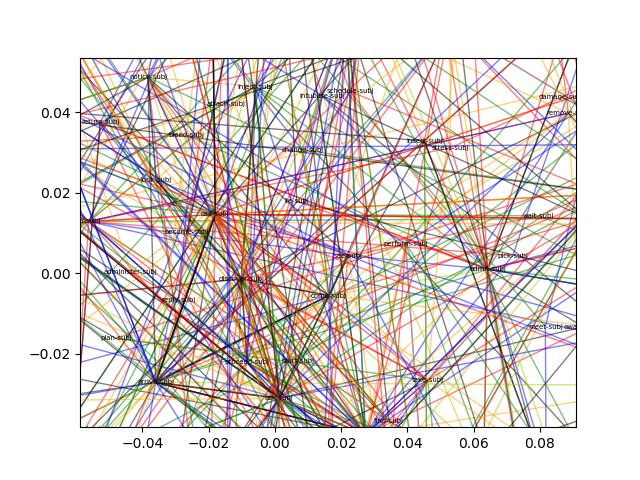

C:\Users\fphub\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\fphub\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


In [13]:
%matplotlib notebook

G = nx.from_numpy_array(A)

pos=nx.spring_layout(G) 

graph_labels = {}
for j in range(len(A[0])):
    graph_labels[j] = labels[j][0]



temp_prot = labels[0][1]
nodelist = [0]
color_index = 0
color_list = ['r','g','b','orange','black','r','y','g','b','orange','black']

for edge_list in node_chains :
    color_index +=1
    nx.draw_networkx_edges(G,pos,edgelist=edge_list, edge_color=color_list[color_index % len(color_list)],width=1,alpha=0.5)

'''
for j in range(1,len(A[0])):
    if labels[j][1] == temp_prot :
        nodelist.append(j)
    else :
        nx.draw_networkx_nodes( G, pos, nodelist=nodelist, node_color=color_list[color_index % len(color_list)], node_size=100, alpha=0.5 )
        nodelist = [j]
        temp_prot = labels[j][1]
        color_index += 1
'''
nx.relabel_nodes(G,graph_labels,False)
nx.draw_networkx_labels(G,pos,graph_labels,font_size=5)
plt.show()


In [61]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=32, walk_length=30, num_walks=200, workers=4) 

model = node2vec.fit(window=10, min_count=1, batch_words=4) 

Computing transition probabilities: 100%|██████████████████████████████████████████| 317/317 [00:00<00:00, 1597.24it/s]


In [67]:
model.wv.most_similar("say-nsubj")

[('announce-nsubj', 0.7048949599266052),
 ('provide-nsubj', 0.7032985091209412),
 ('locate-nsubj', 0.6986777782440186),
 ('hit-nsubj', 0.6650459170341492),
 ('hurt-nsubjpass', 0.6628268957138062),
 ('know-nsubj', 0.476696252822876),
 ('want-nsubj', 0.41168808937072754),
 ('do-nsubj', 0.39214637875556946),
 ('ask-dobj', 0.37592288851737976),
 ('key-nsubj', 0.35769665241241455)]

In [14]:
%matplotlib notebook
plt.clf()
for i in range(128):
    E = [protagonists_parser(narratives[i])]
    A,count,count_tot,labels,node_chains = NEEG_generator(E)
    G = nx.from_numpy_array(A)#,parallel_edges=True,create_using=nx.MultiDiGraph())
    pos=nx.spring_layout(G) 
    graph_labels = {}
    for j in range(len(A[0])):
        graph_labels[j] = labels[j][0]
    temp_prot = labels[0][1]
    nodelist = [0]
    color_index = 0
    color_list = ['b','g','r','c','m','y','k','orange','pink']
    for edge_list in node_chains :
        color_index +=1
        nx.draw_networkx_edges(G,pos,edgelist=edge_list, edge_color=color_list[color_index % len(color_list)],width=3,alpha=0.5)
    #display_chains(E)        
    nx.draw_networkx_edges(G,pos,width=0.5,alpha=0.5)
    nx.draw_networkx_labels(G,pos,graph_labels,font_size=6)
    print(narratives[i])
    plt.show()

    plt.savefig("graphASN"+str(i)+".png")
    plt.clf()

<IPython.core.display.Javascript object>


the 91 y.o. patient was known to suffer from a severe aortic valve stenosis. she also had cognitive disorders with dementia and agitation. one month before, she had broken her right elbow and was operated under general anesthesia (qualified as highly difficult with hemodynamic instability after the interview of the first anesthesiologist). unfortunately, there was a wound infection and she needed another surgery. when she came to the anesthesiologist appointment before the second surgery, the medical doctor didn’t have access to medical data so he decided to postpone the appointment to the day before the surgery. unfortunately, she arrived in the hospital three hours before the surgery. the orthopedic surgeon was in a hurry and pressed the anesthesiologist. he read the last medical data report and chose to use the same anesthesia protocol. shortly after iv induction, the blood pressure and capnography decreased needing three injections of 100 microg of epinephrine and crystalloid to r


during the anesthesiologist’s appointment, the medical doctor discovered that triplets children had to be operated on the same day from different kinds of surgery with the same surgeon (cryptorchidie and phimosis – both side or just one). the three brothers were a perfect replica of each others. the anesthesiologist decided to cancel one of the brother reducing thus the risk of error. finally, both parents declared that they feared to take care of their children the same day at home.



on monday morning after a sunny weekend, during the first general anesthesia procedure, the anesthesiologist was speaking and laughing with his coworkers. it was an iv induction for a minor surgery needing an orotracheal intubation (a.s.a. 1). immediately after intubation, the young patient coughed violently risking to fall off the table. all the staff secured him and the anesthesiologist discovered that he had forgotten to inject the muscle relaxant drug. after the injection, the surgery began without any problem at the discharge.



c-section was decided because of stagnation and fetal heart rate abnormalities at 9: 00 p.m. the patient had an epidural analgesia for the labor. the quality of analgesia seemed to be poor. in the same time, the anesthesiologist on duty was taking care of a patient with septic shock. he decided to call a colleague. when the other anesthesiologist arrived after a delay of about 45 minutes, the anesthesiologist went to the operating room and injected a full dose of local anesthetic for the c-section. the surgeon and the patient were exhausted. when the surgeon began the surgery the patient was really painful but she decided to continue because she was scared about the general anesthesia in this condition. moreover, she declared that she’d suffer if it had been a normal delivery without analgesia. everybody seemed aware of the situation but nobody wanted to say « stop, i’m concerned ». the day after, she didn’t report any post-traumatic stress disorder. the surgeon apologised for this aw


an emergency team was called at 7:00 am for a car accident with a comatose patient incarcerated in her car. a traumatic brain injury was suspected and the glasgow coma scale was 3. the medical doctor decided to secure venous access and the airway. he ordered to be prepared for a crush induction. the crna was anxious because she had to include the patient in a new scientific research protocol with many data to record. she put the venous catheter and used an hemocue to evaluate the hemoglobin value. few minutes later, the patient was extracted from her car and immediately intubated and ventilated. the crna looking for identity card discovered an insulin prescription. the glycemia measured was very low (1.2 mmol/l). the nurse injected iv g30%. after performing the bodyscan in the trauma center, the patient woke up without any damage. she was quickly discharged from the hospital.



an healthy patient came for an anesthesia appointment. after a medical exam, he was supposed to be difficult for the oro-tracheal intubation. he had undergone previous general anesthesia without any difficult intubation reported. few days later, the same anesthesiologist realised the general anesthesia. three attempts were needed for intubation with the use of a videolaryngoscope, a cricoid pressure and an eschmann tracheal tube. no incident was noticed. in the postop ward, while the anesthesiologist was given to him a difficult intubation certificate, he remembered not havin mentioned during pre-anesthesia questioning a similar situation with the delay of the surgery and the use of fiberoptic intubation protocol. the questions during the appointment didn’t allow him to remember such event.



after a difficult surgery (9 hours long), there were two minor surgeries for a man and his wife. they came from africa. during the checking of medical data from the husband, the anesthesiologist discovered a result of blood sample belonging to his wife. then, the woman arrived. she seemed to be exhausted and after a short exam, the medical doctor read that she was diabetic. the glycemia was low and after g30% injection, she recovered. the anesthesiologist was proud of him and proceeded to the general anesthesia. when he arrived in pacu, reading the medical data for a short briefing with the nurse, he discovered that the woman was epileptic and he had injected a contra-indicated pain killer. nothing happened.



in this section, we will report two medication errors that occurred between 11:00 pm and 7:00 am. the first case reported an intrathecal injection of a small dose of suxamethonium for an emergency c-section. the drug supposed to be delivered to the patient was sufentanil. it had a similar labeling with suxamethonium. the nurse and the anesthesiologist didn’t realised that the wrong drug had been injected. no poor outcome was reported. the second case report is about the management of an epidural analgesia in the intensive care unit. the icu nurse was not used to this ward. she called the anesthesiologist because there was an occlusion alarm. the anesthesiologist wanted to inject isotonic saline solution and asked the nurse to find out some. she didn’t know where it was and finally, the medical doctor decided to help himself. he was angry and after the injection of the solution, he discovered that he had injected hypertonic saline solution. nothing happened but the team reported a fear


a certified nurse anesthetist (crna) was working with an anesthesiologist for a patient who underwent an angioplasty. the anesthesiologist who was in charge of the patient wanted to use several iv medication to produce a mild sedation. it was a new procedure for the crna who was stressed. the case took place between 11:00 am and 3:00 pm. the patient airway was mallampati iii with an asa iii status. a few minutes after the beginning of the procedure, the physician went out of the operating room. the crna asked the surgeon if he needed some heparin bolus and the surgeon answered « later ». during the procedure, there were many technical problems and the surgeon was angry. after two hours in the post anesthesia care unit, the patient was painful and suffered from a leg ischemia leading to a reoperation. at this moment, the crna reminded him that he had forgotten to inject heparin bolus.



on saturday morning, two days after a gastric sleeve surgery, a patient suffered from abdominal pain associated with dyspnea. the abdominal scan showed intra-abdominal collection. the surgeon decided to plan an emergency laparoscopy. at 1:00 pm, the patient arrived with the surgeon and his assistant. they left her in the operating room while the anesthesiologist was taking care of another patient. after the end of his previous surgery, the anesthesiologist discovered an hypoxic patient without any iv line and without monitoring. it was decided to put the patient in the recovery room in order to organise the anesthesia protocol and also administrate preload iv fluid before surgery. when the surgeon arrived, he was really angry and didn’t understand the situation arguing why the patient was still awake.



the first case occured at the end of an orthopedic leg surgery and the decompression of the tourniquet. the patient had a regional anesthesia (spinal anesthesia) for this procedure. during the cardio pulmonary rescucitation, the anesthesiologist decided to intubate the patient and he discovered that his dental plate hadn’t been removed before the surgery as needed. it was an unplanned procedure. the surgeon was late and his surgical planning was overbooked. the subscriber reported that he was tired (middle of the day)..



call for help due to respiratory failure during a general anaesthesia for ambulatory proctologic surgery. when the second anaesthesiologist arrived in the operating room, the oxygen level was very low (sao2 = 27 %). the initial team was trying to ventilate and then they decided to proceed to an emergency intubation. unfortunately, the intubation failed two times using specific devices. so the second anaesthesiologist decided to insert a supraglottic airway tube. the insertion was easy leading to a rapid increase of arterial oxygenation. the surgery was performed under general anaesthesia and the patient was discharged after being informed of the incident.



the team reported a situation called “cannot ventilate, cannot intubate” during the anaesthesia of a child with a voluminous lower lip hemangioma evolving toward the pharynx. before this surgery, an embolisation was performed without checking the efficiency of this procedure and sharing information among caregivers involved in the surgery. during the preoperative evaluation, the anaesthesiologist didn’t suspect the size of the hemangioma (“he just saw the top of the iceberg”). fortunately, an urgent tracheotomy was performed under stressful conditions and this procedure saved the life of this child. then he was admitted to intensive care unit.


ValueError: Cannot apply_along_axis when any iteration dimensions are 0

In [11]:
from tqdm import tqdm_notebook

def narrative_embedding(narratives):
    narrative_chains = []
    narrative_embeddings = []
    for i in tqdm_notebook(range(len(narratives))):
        narrative_chains.append(protagonists_parser(narratives[i]))
    
    return(narrative_embeddings)

narrative_embedding(['yesterday i didnt went to the market and I found a big red apple that I immediatly started to not eat it.'])

[[{'protagonist': i,
   'events': [{'id': 0,
     'subj': i,
     'predicat': ['go', 'subj'],
     'obj': None,
     'iobj': to the market},
    {'id': 0,
     'subj': I,
     'predicat': ['find', 'subj'],
     'obj': a big red apple that I immediatly started to not eat it,
     'iobj': None},
    {'id': 0,
     'subj': I,
     'predicat': ['start', 'subj'],
     'obj': None,
     'iobj': immediatly}]},
  {'protagonist': a big red apple that I immediatly started to not eat it,
   'events': [{'id': 0,
     'subj': I,
     'predicat': ['find', 'obj'],
     'obj': a big red apple that I immediatly started to not eat it,
     'iobj': None},
    {'id': 0,
     'subj': None,
     'predicat': ['not eat', 'obj'],
     'obj': it,
     'iobj': None}]}]]

In [20]:
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from nltk.tokenize import word_tokenize


data1 = narratives.tolist()

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data1)]

max_epochs = 10
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

C:\Users\fphub\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


C:\Users\fphub\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model Saved


In [21]:
model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])

V1_infer [ 0.11590084 -0.04255013 -0.02937321 -0.05297888  0.0785589  -0.00435724
  0.04047681 -0.16301143 -0.05943805 -0.03770592  0.06547178  0.08699149
 -0.00635911  0.07442018 -0.02059305  0.09046391 -0.00749271  0.05606966
 -0.06571898  0.08176688]
[('113', 0.8806160092353821), ('99', 0.8598290681838989), ('85', 0.8556598424911499), ('255', 0.8469072580337524), ('6365', 0.8424815535545349), ('924', 0.8375471234321594), ('75', 0.8325303792953491), ('248', 0.8300256133079529), ('13437', 0.8261675834655762), ('35', 0.821302592754364)]
[ 1.3598036  -1.7714113  -3.9618344   1.1578716   2.8670628  -0.579641
 -0.93557364 -5.214711    2.351588   -0.38233182  0.05837437 -0.3413784
  0.40405783 -3.5520358   1.7395914   1.0467405   3.7311697  -2.5172381
 -0.15567899 -2.5077772 ]
